Install dependencies and import librarie

In [3]:
!pip install -q --no-cache-dir \
    "open-clip-torch==2.24.0" \
    "ftfy" "regex" "tqdm" "seaborn" "scikit-learn" "matplotlib"

print("All packages installed!")

import torch
import open_clip
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torchvision import datasets
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on → {device.upper()} {torch.cuda.get_device_name(0) if device=='cuda' else ''}")

All packages installed!


/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Running on → CUDA Tesla T4


Load the CLIP model (ViT-B/16 variant)

In [4]:
# Load model
model, _, preprocess = open_clip.create_model_and_transforms(
    'ViT-B-16', pretrained='laion400m_e31'
)
model.to(device).eval()
tokenizer = open_clip.get_tokenizer('ViT-B-16')

Load Caltech-101 dataset and get class name

In [5]:
# Step 3: Download Caltech-101 and get class names
print("Downloading Caltech-101...")
caltech = datasets.Caltech101(root="./data", download=True)
class_names = caltech.categories  # 101 classes
print(f"Found {len(class_names)} classes, e.g. {class_names[:5]}")


Found 101 classes, e.g. ['Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion']


Evaluate zero-shot accuracy on the test split


Preparing Caltech-101 dataset with proper preprocessing...
Dataset size: 8677 images


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Text features ready. Starting zero-shot evaluation...


Zero-shot evaluation:   0%|          | 0/136 [00:00<?, ?it/s]


Zero-shot Top-1 Accuracy on Caltech-101: 87.55%


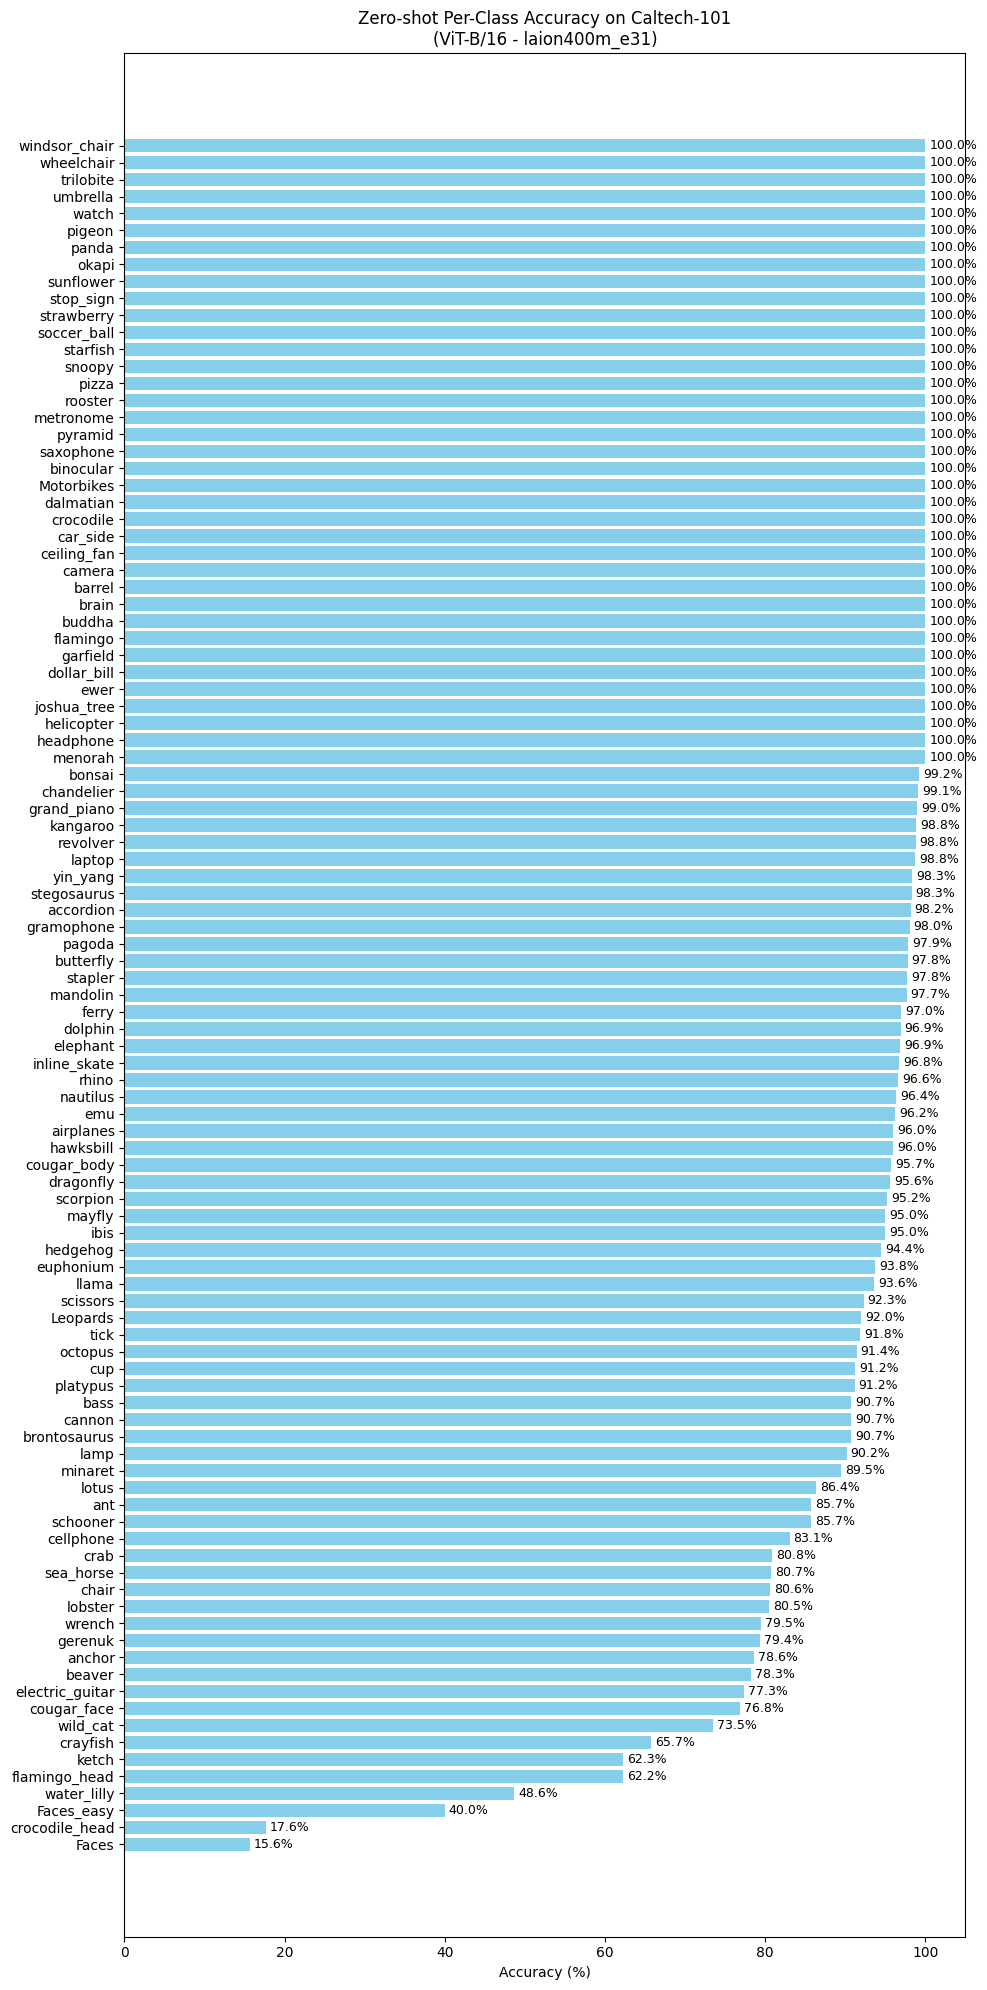

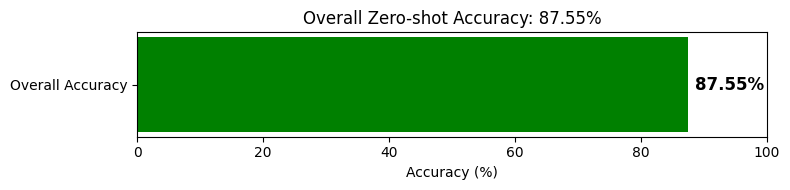

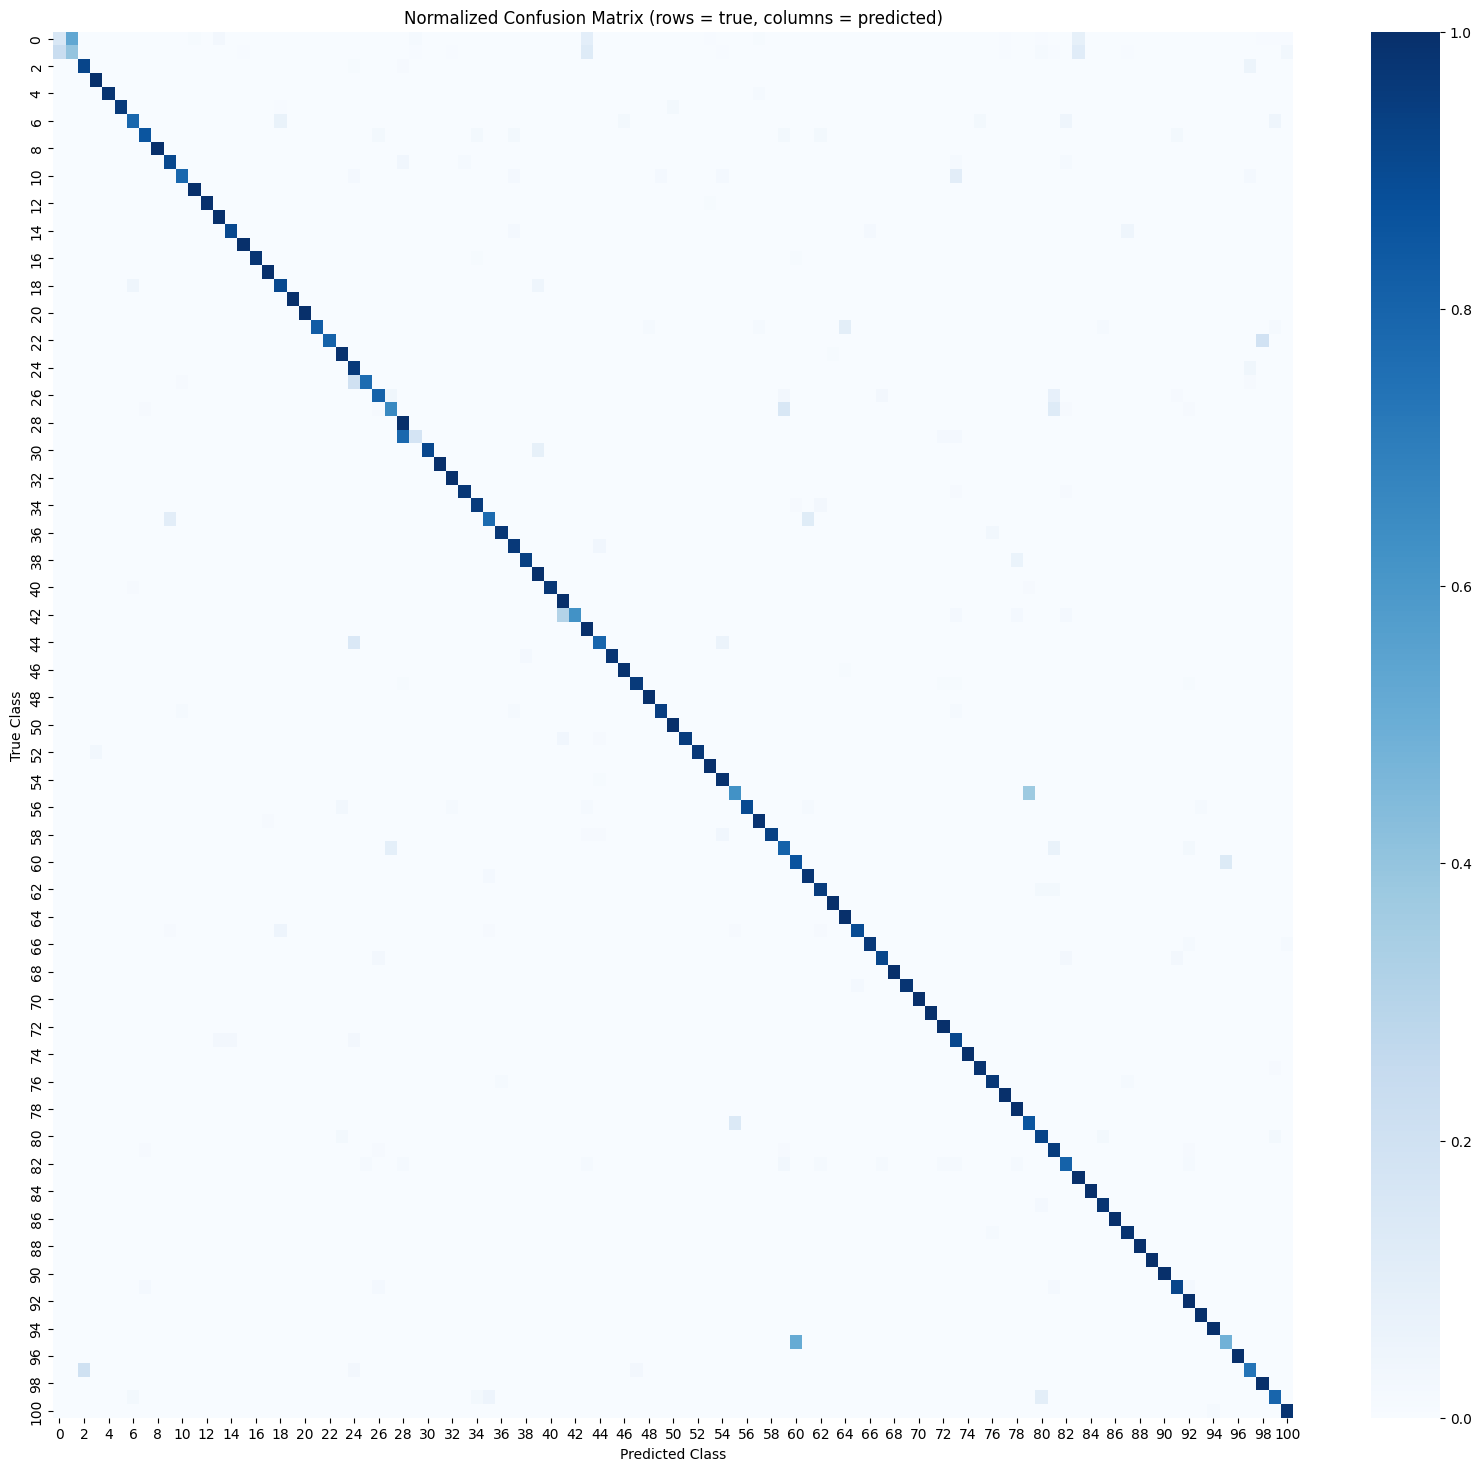


Detailed Classification Report:
                 precision    recall  f1-score   support

          Faces      0.400     0.156     0.225       435
     Faces_easy      0.431     0.400     0.415       435
       Leopards      0.963     0.920     0.941       200
     Motorbikes      0.999     1.000     0.999       798
      accordion      0.964     0.982     0.973        55
      airplanes      1.000     0.960     0.980       800
         anchor      0.892     0.786     0.835        42
            ant      0.923     0.857     0.889        42
         barrel      0.979     1.000     0.989        47
           bass      0.845     0.907     0.875        54
         beaver      0.947     0.783     0.857        46
      binocular      0.868     1.000     0.930        33
         bonsai      1.000     0.992     0.996       128
          brain      0.875     1.000     0.933        98
   brontosaurus      0.975     0.907     0.940        43
         buddha      0.955     1.000     0.977        

In [5]:
# FIXED VERSION: The error occurs because Caltech101 returns raw PIL Images,
# and DataLoader's default collate_fn cannot stack them into a tensor.
# Solution: Apply the preprocessing transform directly in the dataset,
# so the DataLoader receives ready-to-use tensors.

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Re-define the dataset with the open_clip preprocess applied
print("Preparing Caltech-101 dataset with proper preprocessing...")

caltech_transformed = datasets.Caltech101(
    root="./data",
    download=False,  # already downloaded
    transform=preprocess  # This applies Resize, CenterCrop, ToTensor, Normalize exactly as needed by the model
)

print(f"Dataset size: {len(caltech_transformed)} images")
class_names = caltech_transformed.categories

# Create DataLoader – now it will return tensors directly
data_loader = DataLoader(
    caltech_transformed,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# Recompute text features (in case you restarted)
text_prompts = [f"a photo of a {c}." for c in class_names]
with torch.no_grad():
    text_tokens = tokenizer(text_prompts).to(device)
    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

print("Text features ready. Starting zero-shot evaluation...")

# Evaluation
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(data_loader, desc="Zero-shot evaluation"):
        images = images.to(device)          # (batch, 3, 224, 224) tensor, already normalized
        labels = labels.tolist()

        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        # Cosine similarity logits
        logits = image_features @ text_features.T  # (batch, num_classes)

        preds = logits.argmax(dim=-1).cpu().tolist()

        y_true.extend(labels)
        y_pred.extend(preds)

# Metrics
overall_accuracy = accuracy_score(y_true, y_pred)
print(f"\nZero-shot Top-1 Accuracy on Caltech-101: {overall_accuracy * 100:.2f}%")

# Per-class accuracy
per_class_correct = np.zeros(len(class_names))
per_class_total = np.zeros(len(class_names))

for true, pred in zip(y_true, y_pred):
    per_class_total[true] += 1
    if true == pred:
        per_class_correct[true] += 1

per_class_acc = np.divide(per_class_correct, per_class_total,
                          out=np.zeros_like(per_class_correct),
                          where=per_class_total != 0)

# --- Visualizations ---

# 1. Per-class accuracy bar chart (sorted)
sorted_idx = np.argsort(per_class_acc)[::-1]
sorted_classes = [class_names[i] for i in sorted_idx]
sorted_acc = per_class_acc[sorted_idx] * 100

plt.figure(figsize=(10, 20))
bars = plt.barh(sorted_classes, sorted_acc, color='skyblue')
plt.xlabel('Accuracy (%)')
plt.title('Zero-shot Per-Class Accuracy on Caltech-101\n(ViT-B/16 - laion400m_e31)')
plt.gca().invert_yaxis()

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2,
             f'{width:.1f}%', va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()

# 2. Overall accuracy gauge
plt.figure(figsize=(8, 2))
plt.barh(['Overall Accuracy'], [overall_accuracy * 100], color='green')
plt.xlim(0, 100)
plt.xlabel('Accuracy (%)')
plt.title(f'Overall Zero-shot Accuracy: {overall_accuracy * 100:.2f}%')
plt.text(overall_accuracy * 100 + 1, 0, f'{overall_accuracy * 100:.2f}%',
         va='center', ha='left', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# 3. Optional: Normalized confusion matrix (may be large)
cm = confusion_matrix(y_true, y_pred, normalize='true')
plt.figure(figsize=(20, 18))
sns.heatmap(cm, cmap='Blues', cbar=True)
plt.title('Normalized Confusion Matrix (rows = true, columns = predicted)')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# 4. Full classification report (printed)
print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

Training the model

In [6]:
# FIX: The dataset is not found in the current directory because we changed working directory
# We need to use the correct absolute path where it was originally downloaded

import os
from torchvision import datasets

# Go back to the main Colab directory (where the dataset was downloaded earlier)
os.chdir("/content")  # This is the default Colab working directory
print(f"Current working directory reset to: {os.getcwd()}")

# The dataset was downloaded to "./data" relative to the original directory, i.e., /content/data
data_root = "./data"

# Verify if the dataset exists
if not os.path.exists(os.path.join(data_root, "101_ObjectCategories")):
    print("Dataset folder not found! Redownloading...")
    # Redownload if missing (safe to do)
    datasets.Caltech101(root=data_root, download=True)
else:
    print("Dataset found!")

# Now load the full dataset
full_dataset = datasets.Caltech101(root=data_root, download=False)

print(f"Loaded Caltech-101 with {len(full_dataset)} images and {len(full_dataset.categories)} classes.")

Current working directory reset to: /content
Dataset folder not found! Redownloading...
Loaded Caltech-101 with 8677 images and 101 classes.


In [7]:
# FIX: The NameError occurs because train_transform and test_transform were defined in a previous cell that didn't run successfully (due to the grayscale issue).
# We need to re-define them here with the grayscale-to-RGB fix.

from torchvision import transforms
from torchvision.transforms import Compose, RandomResizedCrop, RandomHorizontalFlip, ToTensor, Normalize

# Force RGB + strong training augmentations (standard for CLIP-style fine-tuning)
train_transform = Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),          # Critical: handle grayscale images
    RandomResizedCrop(224, scale=(0.14, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
    RandomHorizontalFlip(p=0.5),
    ToTensor(),
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073),       # OpenAI CLIP / LAION stats
              std=(0.26862954, 0.26130258, 0.27577711)),
])

# Test transform: use the original open_clip preprocess but force RGB first
def rgb_preprocess(img):
    if img.mode != "RGB":
        img = img.convert("RGB")
    return preprocess(img)  # 'preprocess' comes from open_clip.create_model_and_transforms

test_transform = rgb_preprocess

print("train_transform and test_transform defined with grayscale → RGB fix.")

train_transform and test_transform defined with grayscale → RGB fix.


In [8]:
# Now proceed with the split (same as before)

import random
random.seed(42)

train_indices = []
test_indices = []

# Group indices by class
for class_idx in range(len(full_dataset.categories)):
    class_indices = [i for i, (_, label) in enumerate(full_dataset) if label == class_idx]
    random.shuffle(class_indices)

    # Standard protocol: up to 30 for test (some classes have fewer than 30+30)
    n_test = min(30, len(class_indices))
    test_indices.extend(class_indices[-n_test:])
    train_indices.extend(class_indices[:-n_test])

print(f"Train samples: {len(train_indices)} | Test samples: {len(test_indices)}")

# Apply transforms
train_dataset = torch.utils.data.Subset(
    datasets.Caltech101(root=data_root, transform=train_transform, download=False),
    train_indices
)

test_dataset = torch.utils.data.Subset(
    datasets.Caltech101(root=data_root, transform=test_transform, download=False),
    test_indices
)

class_names = full_dataset.categories
num_classes = len(class_names)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

print("Train/test split and loaders ready!")

Train samples: 5647 | Test samples: 3030
Train/test split and loaders ready!


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [9]:
# Ensure model and classifier are loaded (run this if you restarted or lost variables)

model, _, _ = open_clip.create_model_and_transforms('ViT-B-16', pretrained='laion400m_e31')
model.to(device)

class CLIPClassifier(torch.nn.Module):
    def __init__(self, clip_model, num_classes):
        super().__init__()
        self.visual = clip_model.visual
        self.head = torch.nn.Linear(clip_model.visual.output_dim, num_classes)
        torch.nn.init.zeros_(self.head.weight)
        torch.nn.init.zeros_(self.head.bias)

    def forward(self, x):
        return self.head(self.visual(x))

classifier_model = CLIPClassifier(model, num_classes).to(device)

# Linear probe: only train the head
optimizer = torch.optim.AdamW(classifier_model.head.parameters(), lr=1e-3, weight_decay=0.05)

print("Classifier ready for training.")

Classifier ready for training.


In [11]:
# FIX: The error is caused by grayscale images in Caltech-101.
# Some classes (e.g., 'Faces', 'Faces_easy') contain grayscale images → ToTensor() produces shape (1, H, W)
# Then Normalize expects (3, H, W) → broadcast error.

# Solution: Add Convert("RGB") to both train and test transforms to force 3 channels

from torchvision import transforms
from torchvision.transforms import Compose, RandomResizedCrop, RandomHorizontalFlip, ToTensor, Normalize, ConvertImageDtype

# Updated train transform (strong augmentation + force RGB)
train_transform = Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),  # Force 3 channels
    RandomResizedCrop(224, scale=(0.14, 1.0)),  # Stronger crop as in CLIP training
    RandomHorizontalFlip(p=0.5),
    ToTensor(),
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
              std=(0.26862954, 0.26130258, 0.27577711)),
])

# Updated test transform (use the original preprocess but force RGB)
# Since 'preprocess' is a transform pipeline from open_clip, we wrap it
from torchvision.transforms.functional import pil_to_tensor

def rgb_preprocess(img):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return preprocess(img)

test_transform = rgb_preprocess

# Re-create the datasets with fixed transforms
train_dataset = torch.utils.data.Subset(
    datasets.Caltech101(root=data_root, transform=train_transform, download=False),
    train_indices
)

test_dataset = torch.utils.data.Subset(
    datasets.Caltech101(root=data_root, transform=test_transform, download=False),
    test_indices
)

# Re-create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

print("Transforms fixed (grayscale → RGB conversion added)! DataLoaders recreated.")

Transforms fixed (grayscale → RGB conversion added)! DataLoaders recreated.


In [10]:
# Now restart the training - it should run without errors

from tqdm.auto import tqdm
import torch.nn as nn

num_epochs = 20
best_acc = 0.0
best_path = "best_linear_probe.pth"
criterion = nn.CrossEntropyLoss()

# Re-initialize the head (optional, but clean start)
torch.nn.init.zeros_(classifier_model.head.weight)
torch.nn.init.zeros_(classifier_model.head.bias)

# Re-create optimizer for head
optimizer = torch.optim.AdamW(classifier_model.head.parameters(), lr=1e-3, weight_decay=0.05)

for epoch in range(num_epochs):
    classifier_model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = classifier_model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1} | Train loss: {avg_loss:.4f}")

    # Validation
    classifier_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Epoch {epoch+1} [Val]"):
            images, labels = images.to(device), labels.to(device)
            logits = classifier_model(images)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    print(f"Epoch {epoch+1} | Test Accuracy: {acc * 100:.2f}%")

    if acc > best_acc:
        best_acc = acc
        torch.save(classifier_model.state_dict(), best_path)
        print("  → New best model saved!")

print(f"\nLinear probe completed! Best test accuracy: {best_acc * 100:.2f}%")

Epoch 1/20 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:
# Resume training from where it stopped (after epoch 14 → continue epochs 15-20)

# First, load the existing best model weights
classifier_model.load_state_dict(torch.load('/content/best_linear_probe.pth'))

# Re-create the optimizer (important: uses current parameters)
optimizer = torch.optim.AdamW(classifier_model.head.parameters(), lr=1e-3, weight_decay=0.05)

# Set starting point
start_epoch = 15          # Change this if it stopped at a different epoch (e.g., 10 → set to 11)
num_epochs = 20
best_acc = 0.0            # We don't know the previous best_acc, so reset conservatively
                          # (model will only save if it improves during these epochs)
best_path = "best_linear_probe_resumed.pth"  # New filename to avoid overwriting original

criterion = nn.CrossEntropyLoss()

print(f"Resuming training from epoch {start_epoch} to {num_epochs}...")

for epoch in range(start_epoch, num_epochs + 1):
    classifier_model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = classifier_model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch} | Train loss: {avg_loss:.4f}")

    # Validation
    classifier_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Epoch {epoch} [Val]"):
            images, labels = images.to(device), labels.to(device)
            logits = classifier_model(images)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    print(f"Epoch {epoch} | Test Accuracy: {acc * 100:.2f}%")

    if acc > best_acc:
        best_acc = acc
        torch.save(classifier_model.state_dict(), best_path)
        print("  → New best model saved!")

print(f"\nResumed training completed! Best accuracy in these epochs: {best_acc * 100:.2f}%")
print(f"Final model saved as: {best_path}")

Resuming training from epoch 15 to 20...


Epoch 15/20 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 15 | Train loss: 0.2085


Epoch 15 [Val]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 15 | Test Accuracy: 90.23%
  → New best model saved!


Epoch 16/20 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 16 | Train loss: 0.1898


Epoch 16 [Val]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 16 | Test Accuracy: 91.09%
  → New best model saved!


Epoch 17/20 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 17 | Train loss: 0.1805


Epoch 17 [Val]:   0%|          | 0/48 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc0b7d742c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc0b7d742c0>
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
        self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
if w.is_alive():    if w.is_alive():

             ^ ^^^^^^^^^^^^^^^^^^^^
^^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python

Epoch 17 | Test Accuracy: 91.82%
  → New best model saved!


Epoch 18/20 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 18 | Train loss: 0.1648


Epoch 18 [Val]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 18 | Test Accuracy: 91.78%


Epoch 19/20 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 19 | Train loss: 0.1637


Epoch 19 [Val]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 19 | Test Accuracy: 92.11%
  → New best model saved!


Epoch 20/20 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 20 | Train loss: 0.1567


Epoch 20 [Val]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 20 | Test Accuracy: 92.24%
  → New best model saved!

Resumed training completed! Best accuracy in these epochs: 92.24%
Final model saved as: best_linear_probe_resumed.pth


Testing the new best weight model


In [13]:
# Test the newly trained model (best_linear_probe_resumed.pth or your latest checkpoint)

import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# --- Load the trained weights ---
# Change this to your latest checkpoint filename
checkpoint_path = '/content/best_linear_probe_resumed.pth'  # or 'best_linear_probe.pth' if you didn't resume

classifier_model.load_state_dict(torch.load(checkpoint_path))
classifier_model.eval()  # Set to evaluation mode
print(f"Model weights loaded from: {checkpoint_path}")

Model weights loaded from: /content/best_linear_probe_resumed.pth


Testing:   0%|          | 0/48 [00:00<?, ?it/s]


Final Test Accuracy: 92.24%


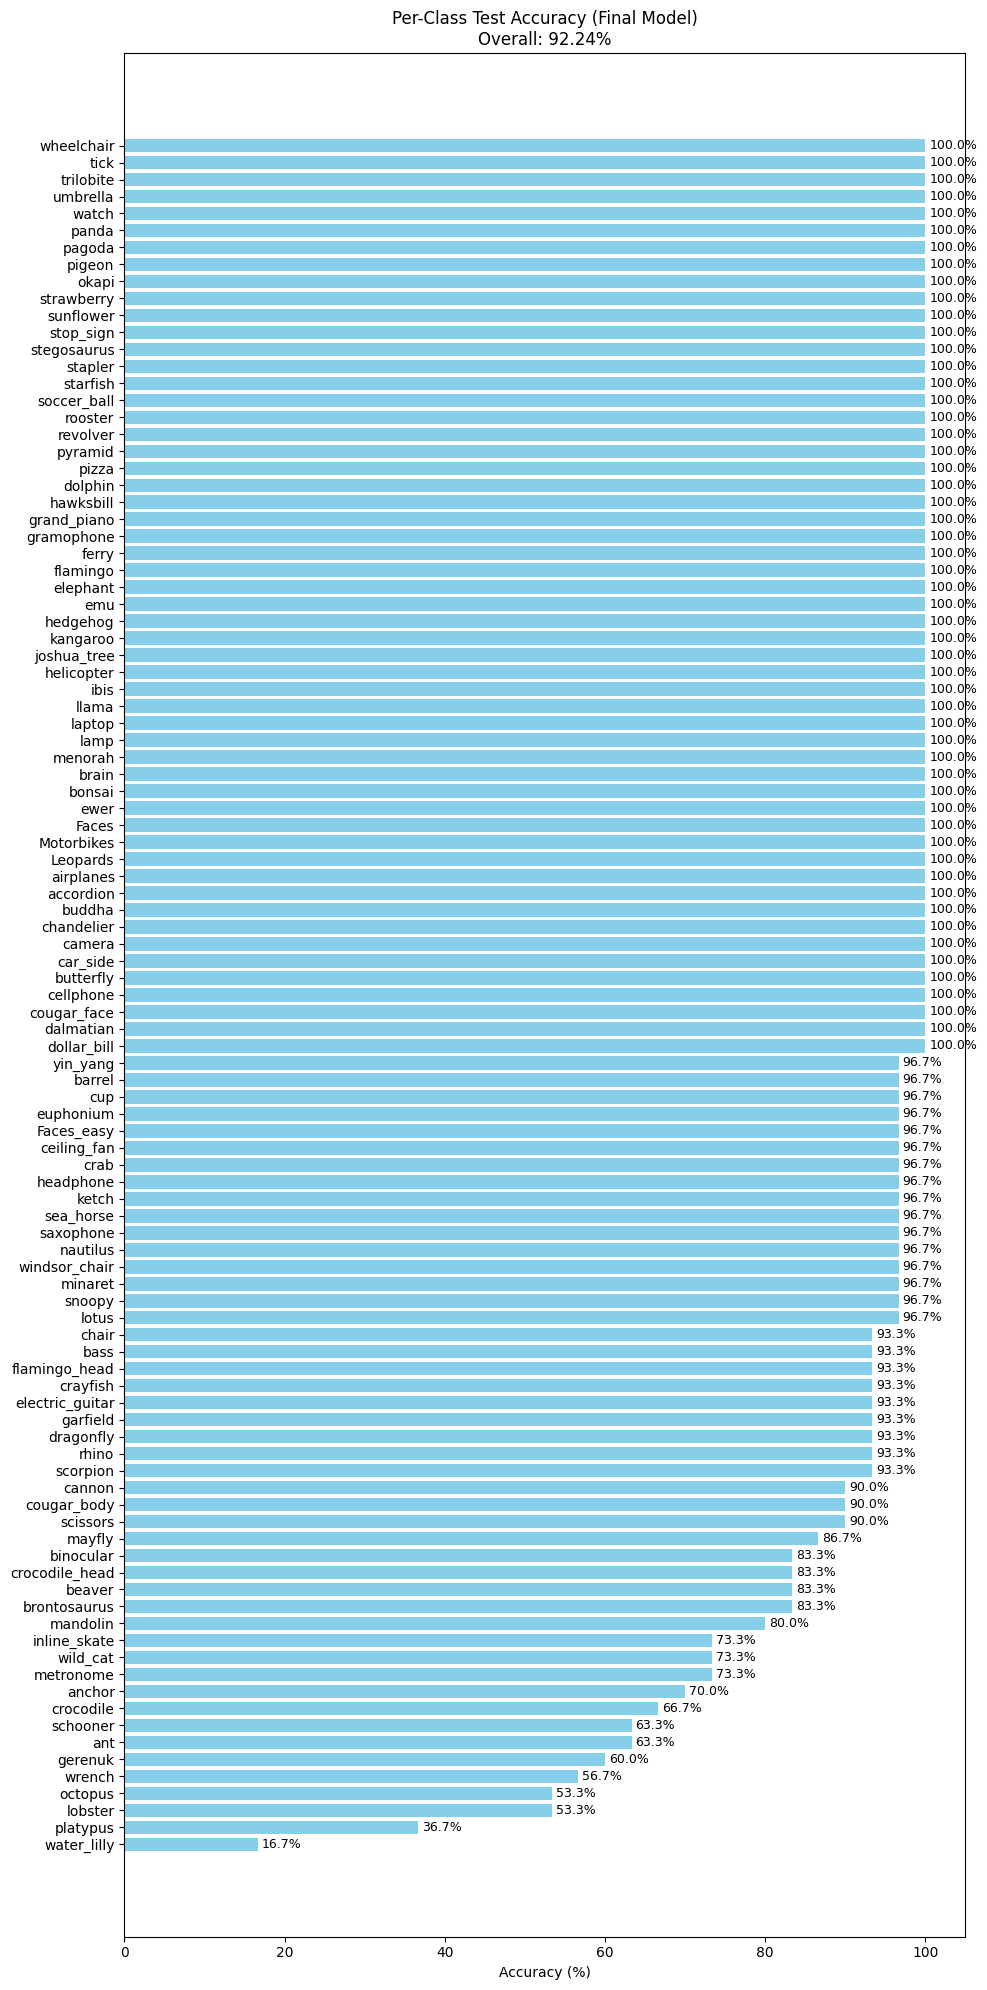

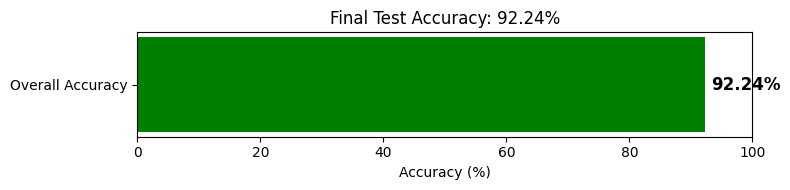

In [14]:
# --- Full evaluation on the test set ---

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        labels = labels.cpu().numpy()

        logits = classifier_model(images)
        preds = logits.argmax(dim=1).cpu().numpy()

        y_true.extend(labels)
        y_pred.extend(preds)

# Overall accuracy
overall_acc = accuracy_score(y_true, y_pred)
print(f"\nFinal Test Accuracy: {overall_acc * 100:.2f}%")

# Per-class accuracy
per_class_correct = np.bincount(y_true, weights=(np.array(y_true) == np.array(y_pred)), minlength=num_classes)
per_class_total = np.bincount(y_true, minlength=num_classes)
per_class_acc = per_class_correct / per_class_total
per_class_acc_percentage = per_class_acc * 100

# Sort for nice plotting
sorted_idx = np.argsort(per_class_acc_percentage)[::-1]
sorted_classes = [class_names[i] for i in sorted_idx]
sorted_acc = per_class_acc_percentage[sorted_idx]

# Plot per-class accuracy
plt.figure(figsize=(10, 20))
bars = plt.barh(sorted_classes, sorted_acc, color='skyblue')
plt.xlabel('Accuracy (%)')
plt.title(f'Per-Class Test Accuracy (Final Model)\nOverall: {overall_acc * 100:.2f}%')
plt.gca().invert_yaxis()

# Add labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2,
             f'{width:.1f}%', va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()

# Overall accuracy gauge
plt.figure(figsize=(8, 2))
plt.barh(['Overall Accuracy'], [overall_acc * 100], color='green')
plt.xlim(0, 100)
plt.xlabel('Accuracy (%)')
plt.title(f'Final Test Accuracy: {overall_acc * 100:.2f}%')
plt.text(overall_acc * 100 + 1, 0, f'{overall_acc * 100:.2f}%',
         va='center', ha='left', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()